In [1]:
!ls ${CUDA_DIR}/nvvm/libdevice

libdevice.10.bc


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# import sys, os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
!set TF_GPU_THREAD_MODE=gpu_private

In [4]:
import tensorflow as tf
import tensorflow.keras as keras
import math
from json import dumps

gpus = tf.config.list_physical_devices("GPU")
print(f"gpus={gpus}")

from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from matplotlib import pyplot as plt
from IPython import display # If using IPython, Colab or Jupyter
import numpy as np
import tensorflow_addons as tfa
import datetime
import random
from sklearn.model_selection import train_test_split
import time

import os
import re
import pathlib

2023-03-02 12:57:23.850986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 12:57:24.413529: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-02 12:57:25.580839: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory
2023-03-02 12:57:25.580898: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or

gpus=[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [5]:
# !wget https://drive.google.com/uc?export=download&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM

In [6]:
print(tf.__version__)

2.10.1


In [7]:
from utils import add_vertical_lines_noise, add_horizontal_lines_noise, TensorboardUtil


In [8]:
import tensorflow_datasets as tfds
from functools import reduce
splits = tfds.even_splits('train', n=200, drop_remainder=True)

In [9]:
IMG_H = 480
IMG_W = 720
IMG_CHANNELS = 3

In [10]:
# train_len = 7164

In [11]:
# BATCH_SIZE = 3
# EPOCHS=100
# steps_per_epoch=int(train_len/BATCH_SIZE)

In [12]:
720/480, 1080/720

(1.5, 1.5)

## Dataset

In [13]:
import tensorflow_datasets as tfds
from image_augmentation import unsharp, pixelation_noise, random_invert_img, random_apply_saturation, ccast


def augment_img(x):
    if tf.random.uniform(shape=[]) > 0.5:
        x = tf.image.random_brightness(x, 0.2)
        x = tf.image.random_contrast(x, 0.2, 0.5)
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    x = random_invert_img(x, p=0.4)
    x = random_apply_saturation(x, p=0.4)
       
    return x

# def split_fn(x, y):
#     print(x, y)
#     return tf.image.resize(x, size=[480, 720]), y

@tf.function
def random_noise_and_resize(y):
    def rn(x): 
        ts = [
            lambda x: add_horizontal_lines_noise(x, random.randint(-10, -8), random.randint(2, 5)),
            pixelation_noise,
#             lambda x: unsharp(np.array(x)), 
            lambda x: add_horizontal_lines_noise(pixelation_noise(x,ranges=[1/3]), random.randint(-10, -8), random.randint(2, 5))
             ]
        fn = random.choice(ts)

        return fn(x)
    
    x = tf.image.resize(y, size=[480, 720])
    return tf.numpy_function(func=rn, inp=[x], Tout=tf.float32), y

def div2k_ds(split, output_shape=(720, 1080)):
    h,w = output_shape
    def set_shapes(image, label):
        image.set_shape((480, 720, 3))
        label.set_shape((h, w, 3))
        return image, label
    
    return tfds.load('div2k', split=split, shuffle_files=True)\
        .map(lambda x: x["hr"])\
        .map(lambda y:tf.image.resize_with_crop_or_pad(y, h, w))\
        .map(lambda z: tf.cast(z, tf.float16))\
        .map(augment_img)\
        .map(random_noise_and_resize)\
        .map(set_shapes)\
        .map(ccast)\

# div2k_ds_train = div2k_ds('train', (200,200)).batch(2)
# div2k_ds_test = div2k_ds('validation').batch(2)

# i = iter(div2k_ds_train)
# for j in range(3):
#     x, y = next(i)
#     plt.figure()
#     plt.imshow(tf.cast(x[0], tf.uint8))
#     plt.figure()
#     plt.imshow(tf.cast(y[0], tf.uint8))

## Training config

In [14]:
class TrainingConfig:
    def __init__(self,
                 dropout_rate=0.1,
                 ff_dropout_rate=0.4,
                 kernel_regularizer = tf.keras.regularizers.L2(0.001),
                 learning_rate=[5e-5, 1e-5, 9e-6, 7e-6],
                optimizer="adamf"):
        self.dropout_rate = dropout_rate
        self.kernel_regularizer = kernel_regularizer
        self.ff_dropout_rate = ff_dropout_rate
        self.learning_rate =learning_rate
        self.optimizer = optimizer
        
    def to_map(self):
        return {"dropout_rate":self.dropout_rate, "kernel_regularizer":self.kernel_regularizer.get_config(), "ff_dropout_rate":self.ff_dropout_rate, "learning_rate":self.learning_rate, "optimizer": self.optimizer}

    def to_hp_map(self):
        assert self.kernel_regularizer.get_config()["l2"] is not None
        return {"dropout_rate":self.dropout_rate, "kernel_regularizer":self.kernel_regularizer.get_config()["l2"], "ff_dropout_rate":self.ff_dropout_rate}
    
    def toString(self):
        return dumps(self.to_map())
    
    def __str__(self):
        return self.toString()
        

In [15]:
import datetime

def now():
    now = datetime.datetime.now()
    return now.strftime('%Y_%m_%d_T%H_%M_%S') + ('_%02d' % (now.microsecond / 10000))

def minute():
    now = datetime.datetime.now()
    return now.strftime('%H_%M') 

minute()

'12_57'

In [16]:
# class MetricsManager:
#     def __init__(self):

In [17]:
from tensorboard.plugins.hparams import api as hp

# HP_NUM_UNITS = hp.HParam('dropout_rate', hp.Discrete([0.1, 0.2]))
# HP_DROPOUT = hp.HParam('ff_dropout_rate', hp.Discrete([0.1,0.4]))
# HP_OPTIMIZER = hp.HParam('kernel_regularizer', hp.Discrete([
#     tf.keras.regularizers.L2(1e-2),
#     tf.keras.regularizers.L2(1e-5),
# ]))
# class HpSearch():
#     def __init__(self, log_dir):
METRIC_ACCURACY = 'accuracy'
METRIC_LOSS = 'loss'
METRIC_MSE = 'mse'

class TensorboardHPSearch():
    def __init__(self, log_dir, name, prefix=f"t{minute()}", v=1):
        self.log_dir_base = log_dir
        self.log_dir = f"{log_dir}/{name}"
        self.log_dir_name = name
        self.prefix = prefix
        self.hp_writer = tf.summary.create_file_writer(self.log_dir)

        
    def init(self, config):
#         with self.hp_writer.as_default():
#             hp.hparams(config.to_hp_map())
        print(f"HPs: {config.to_hp_map()}, logdir={self.log_dir}")
        return hp.KerasCallback(self.log_dir, config.to_hp_map())
            
    def log_results(self, name, loss, accuracy, mse):
        with tf.summary.create_file_writer(f"{self.log_dir_base}/{name}").as_default():
            tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
            tf.summary.scalar(METRIC_LOSS, loss, step=1)
            tf.summary.scalar(METRIC_MSE, mse, step=1)

        
    def hp_search(self,
                  dropout_rate=[0.1, 0.2],
                  ff_dropout_rate=[0.1,0.4],
                  regularizers=[1e-2,1e-5],
                  learning_rate=[(5e-5, 7e-6)],
                  optimizer=["adamf", "adam"],
                  run=lambda config, callback, name:0):
        
        DROPOUT_RATE = hp.HParam('dropout_rate', hp.Discrete(dropout_rate))
        FF_DROPOUT_RATE = hp.HParam('ff_dropout_rate', hp.Discrete(ff_dropout_rate))
        KERNEL_REGULARIZER = hp.HParam('kernel_regularizer', hp.Discrete(regularizers))
        LR = hp.HParam('learning_rate', hp.Discrete(map(lambda x: str(x), learning_rate)))
        OPTIMIZER = hp.HParam('optimizer', hp.Discrete(optimizer))

        
        with self.hp_writer.as_default():
    #                         group = f"t{t}/validation"
            hp.hparams_config(
                hparams=[DROPOUT_RATE, FF_DROPOUT_RATE, KERNEL_REGULARIZER, LR, OPTIMIZER],
                metrics=[
                    hp.Metric(METRIC_ACCURACY, display_name='Accuracy'),
                    hp.Metric(METRIC_LOSS, display_name='Perceptual Loss'),
                    hp.Metric(METRIC_MSE, display_name='MSE')
                ],
            )
                        
        configs = []
        t = 1
        for dr in DROPOUT_RATE.domain.values:
            for ffdr in FF_DROPOUT_RATE.domain.values:
                for reg in KERNEL_REGULARIZER.domain.values:
                    for lr in learning_rate: 
                        for opt in OPTIMIZER.domain.values:
                            config = TrainingConfig(dropout_rate=dr, ff_dropout_rate=ffdr,
                                                   kernel_regularizer=tf.keras.regularizers.L2(reg),
                                                   learning_rate=lr,
                                                   optimizer=opt)

                            hpConfig = {
                                DROPOUT_RATE:dr,
                                FF_DROPOUT_RATE: ffdr,
                                KERNEL_REGULARIZER: reg,
                                LR: str(lr),
                                OPTIMIZER:opt
                            }
                            run(config, hp.KerasCallback(
                                f"{self.log_dir}/{self.prefix}{t}", hpConfig, trial_id = f"{self.prefix}{t}"),
                                f"{self.log_dir_name}/{self.prefix}{t}")
                            configs.append(config)
                            t += 1
        return configs



# tb_util = TensorboardUtil("test")
# [s.toString() for s in tb_util.hp_search()]

## Perceptual loss

In [18]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow.keras.backend as K
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)


class LossNetwork(tf.keras.models.Model):
    def __init__(self):
        super(LossNetwork, self).__init__()
        vgg = VGG16(include_top=False, weights='imagenet')
        vgg.trainable = False
        
        self.selected_layers = ['block1_conv1', 'block2_conv2',"block3_conv3" ,'block4_conv3','block5_conv3']
        self.selected_layer_weights = [0.1, 0.4 , 0.4 , 0.8 , 1.6]
        
        model_outputs = [vgg.get_layer(name).output for name in self.selected_layers]
        self.model = tf.keras.models.Model(vgg.input, model_outputs)
        # mixed precision float32 output
        self.linear = layers.Activation('linear', dtype='float32') 

    def call(self, x):
        x = preprocess_input(x)
        x = self.model(x)
        x = self.linear(x)
        return x

    @tf.function
    def loss(self, x, y):
        h1_list = self.model(x)
        h2_list = self.model(y)
        
        rc_loss = 0.0
        
        for h1, h2, weight in zip(h1_list, h2_list, self.selected_layer_weights):
            h1 = tf.cast(h1, tf.float32)
            h2 = tf.cast(h2, tf.float32)
            h1 = K.batch_flatten(h1)
            h2 = K.batch_flatten(h2)
            rc_loss = rc_loss + tf.cast(tf.reduce_mean((h1 - h2)**2), tf.float32) * weight   
            rc_loss = tf.cast(rc_loss, tf.float32)
      
        return rc_loss

class PeceptualLoss(tf.keras.losses.Loss):
    def __init__(self):
        super(PeceptualLoss, self).__init__()
        self.loss_network = LossNetwork()
        self.loss_network.trainable = False
        
    def call(self, y_true, y_pred):
        return self.loss_network.loss(y_true,y_pred)

    
def build_perceptual_loss(*args, **kwargs):
    return PeceptualLoss()

x = tf.zeros((1,720,1080,3))
y = tf.ones((1,720,1080,3)) * 255.
ploss = build_perceptual_loss()
ploss(x,y)


Some of your GPUs may run slowly with dtype policy mixed_float16 because they do not all have compute capability of at least 7.0. Your GPUs:
  NVIDIA GeForce RTX 3060, compute capability 8.6
  NVIDIA GeForce GTX 960, compute capability 5.2
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


2023-03-02 12:57:28.662280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-02 12:57:28.662586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-02 12:57:28.667524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 12:57:28.792663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

<tf.Tensor: shape=(), dtype=float32, numpy=119029.95>

## Render test images

In [19]:
from utils import ImageRenderer

## Model utils

In [20]:
def conv(filters, kernel_size, strides, norm=False, use_init = True, use_bias=True, activation="relu", config=None, **args):
    return layers.Conv2D(filters,
                         kernel_size=kernel_size,
                         strides=strides,
                         padding="same",
                         use_bias=use_bias,
                         activation=activation,
                         kernel_regularizer=config.kernel_regularizer,
#                          kernel_initializer=tf.keras.initializers.HeNormal(seed=32) if use_init else None,
                         **args)


class Resblock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, config=None, activation="relu", *args, **kwargs):
        super(Resblock, self).__init__(*args, **kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.config = config
        self.activation = activation
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            "conv_size": 3,
            "res_activation": self.activation,
        })
        return config

    def build(self, input_shape):
        self.conv1 = conv(self.filters, kernel_size=self.kernel_size, strides=1, activation=self.activation, config=self.config)
        self.conv2 = conv(self.filters, kernel_size=self.kernel_size, strides=1, activation=self.activation, config=self.config)
        self.conv3 = conv(self.filters, kernel_size=self.kernel_size, strides=1, activation=self.activation, config=self.config)
        self.add = layers.Add()
        self.activation = layers.Activation(self.activation, dtype=tf.float16) 
        
    def call(self, inputs):
        x = self.conv1(inputs)
        y = self.conv2(x)
        y = self.conv3(y)
        out = self.add ([x,y])
        return self.activation(out)


class MyRescale(tf.keras.layers.Layer):
  def __init__(self):
    super(MyRescale, self).__init__()
  def build(self, input_shape):
     self.kernel = self.add_weight("kernel", initializer=tf.keras.initializers.Constant(value=255))


  def call(self, inputs):
   return inputs * self.kernel


class MyDeconv(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides, name, resize_to=None, config=None):
        super(MyDeconv, self).__init__(name=name)
        self.filters = filters
        self.kernel_size = kernel_size
        self.resize_to = resize_to
        self.strides = strides
        self.config = config
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            "resize_to": self.resize_to,
            "strides": self.strides,
        })
        return config
        
    def build(self, input_shape):
        filters = self.filters
        kernel_size = self.kernel_size
        name = self.name
        
        strides = self.strides if isinstance(self.strides, tuple) else (self.strides,self.strides)
                     
        if self.resize_to is None:
            h,w = input_shape[1], input_shape[2]
            self.resize_to = (int(h*strides[0]),int(w*strides[1]))
        
        self.resize_layer = layers.Lambda(lambda x: tf.image.resize(x, self.resize_to, method="nearest"), name=f"resize_nearest_{name}")
        self.resblock = Resblock(filters, kernel_size, config=self.config)
        

    def call(self, inputs):
        x = self.resize_layer(inputs)
        return self.resblock(x)


def maxconv_name():
    i = 0
    while True:
        i += 1
        yield f"max_conv_{i}"

        
max_conv_name = iter(maxconv_name())


def maxpoolconv(filters, pool_kernel_size, kernel_size=3, strides=1, config=None):
    name = next(max_conv_name)
    def fn(x):
#         y = conv(filters, kernel_size=kernel_size, strides=1, name=f"{name}_1", norm=norm)(x)
#         y = conv(filters, kernel_size=kernel_size, strides=1, name=f"{name}_2", norm=norm)(y)
#         x = layers.Add()(x,y)
#         x = layers.ReLU(x)
        x = Resblock(filters, kernel_size, name=f"resblock_{name}_1", config=config)(x)
#         x = conv(filters, kernel_size=kernel_size, strides=1, name=f"{name}_3", norm=norm)(x)
        x = layers.MaxPool2D(pool_kernel_size, name=f"{name}_maxpool")(x)
        return x
    return fn

## Autoencoder

In [21]:
def build_autoencoder_large_v3(config):    
    inputs = keras.Input(shape=(480, 720, 3))
    norm = True
    

    def deconv_with_ff(filters, x, ff, kernel_size, stride, name):
        x = MyDeconv(filters, kernel_size, stride, name=name, resize_to=None, config=config)(x)
        x = layers.SpatialDropout2D(config.dropout_rate)(x)
        x = tf.add(x,ff)
        x = layers.ReLU()(x)
        return x
    
    x = tf.keras.layers.Rescaling(1./255)(inputs)
#     x = layers.Lambda(lambda x: tf.image.per_image_standardization(x))(inputs)
    
    ffs = []
    
    def conv_with_ff(x, filters, strides):
        x = maxpoolconv(filters, strides, config=config)(x)
        ffs.append(layers.SpatialDropout2D(config.ff_dropout_rate)(x))
        return x
#     large_inputs = MyDeconv(16, 3, 1, name="input_ff", resize_to=(720, 1080), norm=norm)(inputs)
#     large_inputs = MyDeconv(32, 3, 1, name="input_ff", resize_to=None, norm=norm)(inputs)
    
#     x = conv(32, 3, 1, name="first_conv1", use_bias=True, norm=norm)(x)
#     x = conv(32, 5, 1, name="first_conv2", use_bias=True, norm=norm)(x)
    x = Resblock(16, 3, name=f"first_resblock", config=config)(x)
    ffs.append(layers.SpatialDropout2D(config.ff_dropout_rate)(x))
    
    x = conv_with_ff(x, 32, 2)
    x = conv_with_ff(x, 64, 2)
    x = conv_with_ff(x, 128, 2)
    x = conv_with_ff(x, 512, 2)
    x = maxpoolconv(1024, (2,3), config=config)(x)
    x = layers.SpatialDropout2D(config.dropout_rate)(x)
        
    ffs.reverse()
    x = conv(1024, 3, 1, name="middle_conv", use_bias=True, config=config)(x)
    
  
    x = deconv_with_ff(512, x, ffs[0], 5, (2,3), "mydeconv7")
    x = deconv_with_ff(128, x, ffs[1], 3, 2, "mydeconv6")
    x = deconv_with_ff(64, x, ffs[2], 5, 2, "mydeconv5")
    x = deconv_with_ff(32, x, ffs[3], 3, 2, "mydeconv4")
    x = Resblock(32, 3, name=f"rb1",config=config)(x)
    x = deconv_with_ff(16, x, ffs[4], 3, 2, "mydeconv3")
    
    x = MyDeconv(16, 3, 1, name="mydeconv2", resize_to=(360, 540), config=config)(x)
    x = Resblock(16, 5, name=f"rb2", config=config)(x)
    x = MyDeconv(16, 3, 2, name="mydeconv1", resize_to=None, config=config)(x)
#     x = deconv_with_ff(16, x, large_inputs, 3, 2, "mydeconv1")
    
    x = conv(16, 5, 1, name="last_conv1", use_bias=True, config=config)(x)
    x = Resblock(9, 3, name=f"last_resconv", config=config)(x)
    x = conv(3, 3, 1, name="output_conv", activation="sigmoid", use_bias=True, config=config)(x)

#     x = deconv(64, kernel_size=1, strides=1, name="prelast_deconv", norm=True)(x)
#     x = deconv(3, kernel_size=1, strides=1, name="last_deconv", norm=True)(x)
#     x = layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding="same", 
#                       activation="sigmoid", kernel_initializer=tf.keras.initializers.HeNormal(seed=32))(x)
    
#     x = MyRescale()(x)
    x = tf.keras.layers.Rescaling(255.)(x)
#     x = tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.uint8))(x)
    
    return tf.keras.Model(inputs, x)


## Defining the best range of learning rates

In [22]:
# best_lr_range = [1e-4, 5e-7]
best_lr_range = [5e-6, 5e-7]

initial_learning_rate = best_lr_range[0]
search_epochs = 100

def lr_from_search(epochs):
    lrs = tf.linspace(best_lr_range[0], best_lr_range[1], epochs, name=None, axis=0)
    def fn(epoch, lr):
        return lrs[epoch]
    return fn

In [23]:
def lr_from_range(epochs, lr_range):
    start,end = lr_range
    lrs = tf.linspace(start, end, epochs, name=None, axis=0)
    def fn(epoch, lr):
        if epoch > epochs:
            return end
        return lrs[epoch]
    return fn
    
lr_from_range(10, (5e-6, 5e-7))(4, 0.1)

<tf.Tensor: shape=(), dtype=float32, numpy=3e-06>

In [24]:
class RangedExpDecay(tf.keras.optimizers.schedules.ExponentialDecay):
    def __init__(self, end, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.end = end
        
    def __call__(self, step):
        return tf.math.minimum(super().__call__(step), self.end)

def schedule_exp_lr_range(start, end):
    return RangedExpDecay(
        end,
        start,
        decay_steps=50,
        decay_rate=0.95,
        staircase=False)

### Get an exponential rate optimizer from a range of learning rates

In [25]:
from utils import getExponentialOptimizer, getPieceWiseOptimizer
   

# ran = getDecayRateOptimizer(1e-8,1e-3, 10)
ran = getPieceWiseOptimizer([0.1, 0.2, 0.1], 11)
for i in range(11):
    print(ran(i))

(11,) ls=[0.1   0.1   0.1   0.1   0.15  0.2   0.2   0.175 0.15  0.125 0.1  ]
epochs_per_range = 5, boundaries=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
tf.Tensor(0.1, shape=(), dtype=float32)
tf.Tensor(0.1, shape=(), dtype=float32)
tf.Tensor(0.1, shape=(), dtype=float32)
tf.Tensor(0.1, shape=(), dtype=float32)
tf.Tensor(0.15, shape=(), dtype=float32)
tf.Tensor(0.2, shape=(), dtype=float32)
tf.Tensor(0.2, shape=(), dtype=float32)
tf.Tensor(0.175, shape=(), dtype=float32)
tf.Tensor(0.15, shape=(), dtype=float32)
tf.Tensor(0.125, shape=(), dtype=float32)
tf.Tensor(0.1, shape=(), dtype=float32)


## Gradient accumulator

In [26]:
from utils import CustomTrainStep

Best result yet:

- In 150/300 epochs, with ranges best_lr_range = [3e-5, 5e-7] and linspace of size 300.

## Trainer tool

In [27]:
import tensorflow as tf
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping
from time import time
import json

class LRMetric(tf.keras.metrics.Mean):
    def __init__(self, model, name="lr_metric", **kwargs):
        super(LRMetric, self).__init__(name=name, **kwargs)
        self.model = model
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        super().update_state(self.model.optimizer.lr)
        
class LRMetric(tf.keras.metrics.Metric):
    def __init__(self, model, name="lr_metric", **kwargs):
        super(LRMetric, self).__init__(name=name, **kwargs)
        self.model = model
        self.lr = self.add_weight(name='lr', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.lr.assign(self.model.optimizer.lr)

    def result(self):
        return self.lr

class GradientUpdates(tf.keras.metrics.Metric):
    def __init__(self, model, name='gradient_updates_metric', **kwargs):
        super(GradientUpdates, self).__init__(name=name, **kwargs)
        self.model = model
        self.true_positives = self.add_weight(name='gradient_updates', initializer='zeros', dtype=tf.int32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.true_positives.assign(self.model.update_count)

    def result(self):
        return self.true_positives

class Trainer:
    def __init__(self, name, output_size):
        self.name = name
        self.output_size = output_size
        self.v = 1
        self.lossFn = build_perceptual_loss(input_shape=(self.output_size[0], self.output_size[1], 3))
        self.aggregate = False
        self.useLRRange = False
        self.callbacks = []
        self.early_stop = False
        self.n_gradients = None
        self.lr_range = None
        self.loss_fn_name = "perceptual_loss"
        self.opt = None
        self.lrs = None
        self.tb_util = None
        self.run_eagerly = False
        self.use_hp = False
        self.log_dir = None
        self.saved_model_name = None
        self.reduce_callback = None
        self.afterTrainFn: lambda x:x
#         print("clear session:")
#         tf.keras.backend.clear_session()

    def withCallbacks(self, callbacks = []):
        self.callbacks = callbacks
        return self
        
    def withVersion(self, v):
        self.v = v
        return self
        
    def setLoss(self, loss_name, lossFn):
        self.lossFn = lossFn
        self.loss_fn_name = loss_name
            
    def withMSEPerceptualLoss(self, ploss_downscale=10000):
        perceptual_loss = build_perceptual_loss(input_shape=(self.output_size[0], self.output_size[1], 3))
        mse = tf.keras.losses.MeanSquaredError()
        def custom_loss(x,y):
            return tf.cast(mse(x,y), tf.float32) * (perceptual_loss(x,y)/tf.cast(ploss_downscale, tf.float32))
        self.lossFn = custom_loss
        self.loss_fn_name = "mse_perceptual_loss"
        self.add_hp_callback = None
        return self
        
    def withEagerRun(self, active=True):
        self.run_eagerly = active
        return self
    
    def withLRRange(self, lr_range):
        self.lr_range = lr_range
        self.useLRRange = True
        return self
    
    def withFindBestLR(self, lr_range, epochs):       
        self.lrs = tf.keras.callbacks.LearningRateScheduler(getExponentialOptimizer(lr_range[0],lr_range[1],epochs), verbose=1)
        return self
    
    def withLRScheduler(self, lrs):
        self.lrs = lrs
        return self
    
    def withOptimizer(self, opt):
        self.opt = opt
        return self
    
    def withSaveModel(self, model_name):
        self.saved_model_name = model_name;
        return self
        
    def withGradientAggregation(self, n_gradients=3):
        self.aggregate = True
        self.n_gradients = n_gradients
        return self
        
    def getCheckpointPath(self):
        return f'./prepa_{self.name}_ckpt'
    
    def getSavedModelPath(self):
        return f'./saved_models/{self.name}_{self.v}'
    
    
    '''
        Use profile batch like this: profile_batch="5,10"
    '''
    def withTensorboard(self, logs_dir, profile_batch=0, use_hp=False):
        log_dir = f"./{logs_dir}/{self.name}"
        self.log_dir = log_dir
        self.tb_util = TensorboardUtil(log_dir)
        self.use_hp = use_hp
        self.callbacks.append(self.tb_util.get_callback(profile_batch=profile_batch))
        return self           

    def withEarlyStopping(self, restore_best_weights=True, patience=5):
        self.early_stop = True
        self.callbacks.append(EarlyStopping(monitor='val_loss', restore_best_weights=restore_best_weights, patience=patience, min_delta=0.))
        return self
    
    def getTrainingConfig(self):
        return {
            "name":self.name,
            "version": self.v,
            "output_size": self.output_size,
            "aggregate_gradients": self.aggregate,
            "n_gradients": self.n_gradients,
            "lr_range": self.lr_range,
            "loss_fn_name": self.loss_fn_name,
            "model_path": self.getSavedModelPath(),
            "early_stop": self.early_stop
        }
    
    def withReduceLROnPlateau(self,
                monitor='val_loss',
                factor=0.7,
                patience=4,
                cooldown=1,
                min_lr=5e-7):
        self.reduce_callback = tf.keras.callbacks.ReduceLROnPlateau(
                monitor=monitor,
                factor=factor,
                patience=patience,
                cooldown=cooldown,
                min_lr=min_lr)
        return self
    
    def validation_results(self, model, dataset):     
        #loss: 214513.0625 - gradient_upds: 2.0000 - lr_metric: 5.0000e-05 - mse: 6808.1318 - accuracy: 0.3310
        if self.aggregate:
            loss, gradient_upds, lr_metric, mse, accuracy = model.evaluate(dataset)
        else:
            loss, lr_metric, mse, accuracy = model.evaluate(dataset)
        return {
            "accuracy": accuracy,
            "loss":loss,
            "mse":mse
        }
    
    def onAfterTrain(self, fn):
        self.afterTrainFn = fn
        return self
    
        
    def get_lr(self, initial_lr):
        if self.lrs is not None:
            lr_schedule = initial_lr
            self.callbacks.append(self.lrs)
#         elif self.useLRRange and self.lrs is None:
#             assert initial_lr == self.lr_range[0]
#             lr_schedule=self.lr_range[0]
#             self.callbacks.append(tf.keras.callbacks.LearningRateScheduler(getPieceWiseOptimizer(self.lr_range,epochs), verbose=1))
        elif self.useLRRange and self.reduce_callback:
            print(f"Using LRRange with reduce callback: {self.useLRRange}, lr={initial_lr}")
            lr_schedule=initial_lr
            self.callbacks.append(self.reduce_callback)
        else:
            print(f"Using LR: {initial_lr}")
            lr_schedule=initial_lr
            self.opt
        return lr_schedule

    
    def getTrainingConfigPreTrain(self, epochs):
        conf = self.getTrainingConfig()
        conf["time"] = time()
        conf["epochs"] = epochs
        return conf
    
    def saveTrainingConfig(self, epochs):
        file1 = open("training.log", "a")  # append mode
        file1.write(json.dumps(self.getTrainingConfigPreTrain(epochs)))
        file1.write("\n")
        file1.close()
    
    def train(self, autoencoder, train_ds, test_ds, epochs, initial_lr, load_checkpoint=True, config=None):
        metrics = []
        
        if self.tb_util:
            self.tb_util.log_text(config.toString(), "training_config", step=0)
        
        if self.aggregate:
            model = CustomTrainStep(n_gradients=self.n_gradients, autoencoder=autoencoder)
            metrics.append(GradientUpdates(model, name="gradient_upds"))
        else:
            model = autoencoder
        
        metrics.append(LRMetric(model, name="lr_metric"))
        
        self.saveTrainingConfig(epochs)
        
#         self.add_hp_callback(config)
        
        lr_schedule=self.get_lr(initial_lr)
        print(f"lr_schedule={lr_schedule}")
        
        if self.opt is None or config.optimizer=="adam":
            self.opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#             self.opt = tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=lr_schedule, beta_1=0.8, beta_2=0.99)
            self.opt = mixed_precision.LossScaleOptimizer(self.opt)
        
            
        checkpoint_dir = f'./prepa_{self.name}_ckpt'
        checkpoint = tf.train.Checkpoint(model=autoencoder, optimizer=self.opt)
        ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)
        
        if load_checkpoint and ckpt_manager.latest_checkpoint:
    #             checkpoint.restore(ckpt_manager.latest_checkpoint)
                checkpoint.restore(ckpt_manager.latest_checkpoint).expect_partial()
        else:
            print("No checkpoints found or loaded")
        
        def save_checkpoint(batch, logs):
            ckpt_save_path = ckpt_manager.save()
            
        images_renderer = ImageRenderer(4).withTensorboard(self.tb_util)
        def print_images(batch, logs):
            images_renderer.render(model=lambda x:model.predict(x, verbose=0), datasets=(train_ds, test_ds), batch=batch)
#             print_validation(lambda x:model(x, training=False), batch_size=2, save=False, path="./", datasets=(train_ds, test_ds))
      
        def initial_print(logs):
            print_images(0, logs)
    
        def clear_print(batch, logs):
            if batch % 5 == 0:
                display.clear_output()
                
        def on_epoch_end(batch, logs):
            clear_print(batch, logs)
            print_images(batch, logs)
            save_checkpoint(batch, logs)
            
        self.callbacks.append(LambdaCallback(on_train_begin=initial_print ,on_epoch_end=on_epoch_end))
        metrics.append("mse")
        metrics.append("accuracy")
        
        print(self.callbacks)
        
        model.compile(optimizer=self.opt, loss=self.lossFn, metrics=metrics, run_eagerly=self.run_eagerly)
        model.fit(train_ds.prefetch(tf.data.AUTOTUNE),
                                    epochs=epochs,
                                    validation_data=test_ds.prefetch(tf.data.AUTOTUNE),
                                    callbacks=self.callbacks)
        
        results = self.validation_results(model, test_ds)
        
        model_path = self.getSavedModelPath()
        model.save(self.getSavedModelPath())
        if self.saved_model_name is not None:
            model.save(self.saved_model_name)
        print(f'model saved to: {model_path}')
        self.afterTrainFn(model)
        return model_path, results, model
    
# t = Trainer("test_model", (720, 1080))\
#     .withMSEPerceptualLoss()\
#     .withLRRange((6e-5, 5e-8))\
#     .withGradientAggregation()\
#     .withTensorboard("prepa_autencoder_logs")\
#     .withEarlyStopping()

# # t.saveTrainingConfig(100)
# t.getTrainingConfig()


## Training

In [28]:
# epochs = 20 
# weights_path, ghistory, model = Trainer("d_and_s_srch_lr", (720, 1080))\
#     .withFindBestLR((5e-8, 2e-3), epochs)\
#     .withGradientAggregation(4)\
#     .withTensorboard("prepa_autencoder_logs", profile_batch=0)\
#     .train(
#         build_autoencoder_large_v3(),
#         div2k_ds("train").batch(4),
#         div2k_ds("validation").batch(4),
#         epochs,
#         1e-8,
#         load_checkpoint=False)

# 1e-4 : 7e-6

In [29]:
kk = 2e-4
for i in range(10):
    kk *= 0.7
    print(kk)

0.00014
9.799999999999998e-05
6.859999999999999e-05
4.801999999999999e-05
3.3613999999999994e-05
2.3529799999999993e-05
1.6470859999999992e-05
1.1529601999999994e-05
8.070721399999996e-06
5.649504979999997e-06


In [30]:
# epochs = 150
# # lr = (5e-5, 7e-6)
# # train_config = TrainingConfig()

# # tb_util = TensorboardUtil("test")
# # [s.toString() for s in tb_util.hp_search()]

# log_dir = "prepa_autencoder_logs"
# name = f"aenc"

# hpSearch = TensorboardHPSearch(log_dir, name)

# def runTest(config, hp_callback, tname):
#     lr = config.learning_rate
#     weights_path, results, model = Trainer(tname, (720, 1080))\
#         .withCallbacks([hp_callback])\
#         .withLRRange(lr)\
#         .withTensorboard(log_dir)\
#         .train(
#                 build_autoencoder_large_v3(config),
#                 div2k_ds("train").batch(3),
#                 div2k_ds("validation").batch(3),
#                 epochs,
#                 lr[0],
#                 load_checkpoint=False,
#                 config=config)
    
#     hpSearch.log_results(tname, results["loss"], results["accuracy"], results["mse"])
#     tf.keras.backend.clear_session()

# TensorboardHPSearch(log_dir, name).hp_search(
#     dropout_rate=[0.1],
#     ff_dropout_rate=[0.1],
#     regularizers=[1e-2],
#     learning_rate=[[2e-4]],
#     optimizer=["adam"],
#     run=runTest)
    

In [31]:
# epochs = 5
# lr = 2e-07
# model_name = "aenc/t02_071"

# train_config = TrainingConfig(dropout_rate=0.1,
#                  ff_dropout_rate=0.1,
#                  kernel_regularizer = tf.keras.regularizers.L2(0.00001),
#                  learning_rate=[lr],
#                 optimizer="adam")
# weights_path, ghistory, model = Trainer(model_name, (720, 1080))\
#     .withVersion(1.2)\
#     .withLRRange([3.9546e-06])\
#     .withTensorboard("prepa_autencoder_logs")\
#     .train(
#         build_autoencoder_large_v3(train_config),
#         div2k_ds("train").batch(3),
#         div2k_ds("validation").batch(3),
#         epochs,
#         lr,
#         load_checkpoint=True,
#         config=train_config)

In [32]:
# epochs = 1
# lr = 8e-06
# model_name = "aenc/t02_071"

# def scheduler(epoch, lr):
#     if epoch < 7:
#         return 1e-07
#     else:
#         return 8e-07


# train_config = TrainingConfig(dropout_rate=0.1,
#                  ff_dropout_rate=0.1,
#                  kernel_regularizer = tf.keras.regularizers.L2(0.00001),
#                  learning_rate=[lr],
#                 optimizer="adam")
# weights_path, ghistory, model = Trainer(model_name, (720, 1080))\
#     .withVersion(1.2)\
#     .withLRScheduler(tf.keras.callbacks.LearningRateScheduler(scheduler))\
#     .withTensorboard("prepa_autencoder_logs")\
#     .getSavedModelPath("ae")
#     .train(
#         build_autoencoder_large_v3(train_config),
#         div2k_ds("train").batch(3),
#         div2k_ds("validation").batch(3),
#         epochs,
#         lr,
#         load_checkpoint=True,
#         config=train_config)

In [33]:
# tf.keras.applications.ResNet50V2(weights="imagenet", include_top=False, input_shape=(480, 720, 3)).summary()

In [34]:
# def get_self_attention():
#     query_input = tf.keras.Input(shape=(None,), dtype='int32')
#     value_input = tf.keras.Input(shape=(None,), dtype='int32')

#     # Embedding lookup.
#     token_embedding = tf.keras.layers.Embedding(input_dim=1000, output_dim=64)
#     # Query embeddings of shape [batch_size, Tq, dimension].
#     query_embeddings = token_embedding(query_input)
#     # Value embeddings of shape [batch_size, Tv, dimension].
#     value_embeddings = token_embedding(value_input)

#     # CNN layer.
#     cnn_layer = tf.keras.layers.Conv1D(
#         filters=100,
#         kernel_size=4,
#         # Use 'same' padding so outputs have the same shape as inputs.
#         padding='same')
#     # Query encoding of shape [batch_size, Tq, filters].
#     query_seq_encoding = cnn_layer(query_embeddings)
#     # Value encoding of shape [batch_size, Tv, filters].
#     value_seq_encoding = cnn_layer(value_embeddings)

#     # Query-value attention of shape [batch_size, Tq, filters].
#     query_value_attention_seq = tf.keras.layers.Attention()(
#         [query_seq_encoding, value_seq_encoding])

#     # Reduce over the sequence axis to produce encodings of shape
#     # [batch_size, filters].
#     query_encoding = tf.keras.layers.GlobalAveragePooling1D()(
#         query_seq_encoding)
#     query_value_attention = tf.keras.layers.GlobalAveragePooling1D()(
#         query_value_attention_seq)

#     # Concatenate query and document encodings to produce a DNN input layer.
#     input_layer = tf.keras.layers.Concatenate()(
#         [query_encoding, query_value_attention])
    
    
def hw_flatten(x) :
    batch_size, height, width, num_channels = x.get_shape().as_list()
    return tf.reshape(x, shape=[-1, height*width, num_channels])

def get_self_attention(x, channels, config):
    max_pooling = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
   strides=(1, 1), padding='valid')
    
    batch_size, height, width, num_channels = x.get_shape().as_list()
    f = conv(channels // 8, 1, 1, name='f_conv', config=config)(x)  # [bs, h, w, c']
    f = max_pooling(f)

    g = conv(channels // 8, 1, 1, name='g_conv', config=config)(x)  # [bs, h, w, c']

    h = conv(channels // 2, 1, 1, name='h_conv', config=config)(x)  # [bs, h, w, c]
    
    h = max_pooling(h)
    
    print(f"g={g} f={f}")

    # N = h * w
    s = tf.matmul(hw_flatten(g), hw_flatten(f), transpose_b=True)  # # [bs, N, N]

    beta = tf.nn.softmax(s)  # attention map

    o = tf.matmul(beta, hw_flatten(h))  # [bs, N, C]
    gamma = tf.Variable(0.0, name="gamma", dtype=tf.float16)

    o = tf.reshape(o, shape=[-1, height, width, num_channels // 2])  # [bs, h, w, C]
    o = conv(channels, 1, 1, name='attn_conv', config=config)(o)
    x = tf.cast(x, tf.float16)
    x = gamma * o + x
    return x

In [35]:
tf.zeros((2,12,12,3)).shape.as_list()

[2, 12, 12, 3]

In [36]:
class MyAttention(tf.keras.layers.Layer):
    def __init__(self, config=None, *args, **kwargs):
        super(MyAttention, self).__init__(*args, **kwargs)
        self.multihead = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=2, attention_axes=(1,2))
        self.rescaling = tf.keras.layers.Rescaling(1./255)
        self.activation = layers.LeakyReLU()
        self.ishape = ()
        self.config = config
        self.w = tf.Variable(1, name="weight",dtype=tf.float16)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "multihead": self.multihead.get_config(),
            "rescaling": self.rescaling.get_config(),
            "activation": self.activation.get_config()
        })
        return config

    def build(self, input_shape):
        batches, width, height, filters = input_shape.as_list()
        self.ishape = (width, height)
        self.conv = conv(filters, 3, 1, config=self.config, activation="leaky_relu")
     
        
    def call(self, inputs1, original_inputs):
        y = tf.cast(original_inputs, tf.float16)
        batch, width, height, filters = inputs1.shape.as_list()
        y = self.rescaling(y)
        y =tf.image.resize(
            y,
            (width, height),
            preserve_aspect_ratio=False,
            antialias=False,
            name=None)
        
        y = self.multihead(y,y)
        y = self.conv(y)
        x = tf.add(inputs1,self.w*y)
        return self.activation(x)

train_config = TrainingConfig(dropout_rate=0.1,
             ff_dropout_rate=0.1,
             kernel_regularizer = tf.keras.regularizers.L2(0.00001),
             learning_rate=[1e-4],
            optimizer="adam")
# a = tf.zeros((1,24,24,128))
# b = tf.zeros((1,12,12,3))
# la = MyAttention(config=train_config)
# print(la.get_config())

# x = MyAttention(config=train_config)(a,b)
# x

In [100]:
class FFLayer(tf.keras.layers.Layer):
    def __init__(self, config=None, *args, **kwargs):
        super(FFLayer, self).__init__(*args, **kwargs)
        self.activation = layers.ReLU()
        self.config = config
        self.w = tf.Variable(initial_value=1, dtype='float16',trainable=True)
        
    
    def get_config(self):
        config = super().get_config()
        config.update({
#             "multihead": self.multihead.get_config(),
#             "rescaling": self.rescaling.get_config(),
            "activation": self.activation.get_config(),
            "resblock": self.resblock.get_config()
        })
        return config

    def build(self, input_shape):
        batches, width, height, filters = input_shape.as_list()
        self.conv = layers.Conv2D(filters,
                         kernel_size=1,
                         strides=1,
                         padding="same",
                         use_bias=True,
                         activation=self.activation,
                         kernel_regularizer=self.config.kernel_regularizer)
        self.resblock = Resblock(filters, 3, activation="relu", config=self.config)
        self.ishape = (width, height)
        self.norm1 = tf.keras.layers.Normalization(axis=None)
        self.norm2 = tf.keras.layers.Normalization(axis=None)
#         self.conv = conv(filters, 3, 1, config=self.config, activation="leaky_relu")
     
        
    def call(self, inputs1, original_inputs):
#         x = self.norm1(original_inputs)
#         x = self.conv(x)
# #         original_inputs= tf.cast(original_inputs, tf.float16)
# #         print(inputs1, original_inputs)
#         x = tf.add(inputs1, x * self.w)
#         x = self.activation(x)
#         x = self.resblock(x)
#         return self.conv(x)
#         return inputs1
        x = inputs1
        return x

train_config = TrainingConfig(dropout_rate=0.1,
             ff_dropout_rate=0.1,
             kernel_regularizer = tf.keras.regularizers.L2(0.00001),
             learning_rate=[1e-4],
            optimizer="adam")

# FFLayer(train_config)(tf.zeros((1,13,13,3)), tf.zeros((1,12,12,3)))

   
#     x = tf.concat([x,inputs2], axis=-1)
#     x = conv(512, 1)(x)
#     x = tf.add(x,tf.cast(inputs2, tf.float16))
#     x = layers.LeakyReLU()(x)
    
#     x = MyAttention(config)(x, original_inputs)
#     y = resize_input(original_inputs, [15*2,22*2])
#     y = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=2, attention_axes=(1,2))(y,y)
#     y = conv(256, 3, 1, config=config)(y)
#     x = tf.add(x,y)
#     x = layers.ReLU()(x)
    

In [101]:
from tensorflow.keras.applications import ResNet50V2 as ResNet
from tensorflow.keras.initializers import GlorotUniform


def deconv(filters, kernel_size, scale):
    def fn(x):
        x = layers.Conv2D(filters * (scale ** 2), kernel_size, padding='same', activation="relu")(x)
        return tf.nn.depth_to_space(x, scale)
    return fn
#     return layers.Conv2DTranspose(filters, kernel_size, padding='same', strides=scale)


def resize_input(inputs, output_shape=(120, 176), rescale_input=True):
    oh = output_shape[0]
    ow = output_shape[1]
    y = tf.keras.layers.Rescaling(1./255)(inputs) if rescale_input else inputs
    y = tf.cast(y, tf.float16)
    y = tf.image.resize(
        y,
        [oh,ow],
        preserve_aspect_ratio=False,
        antialias=False,
        name=None)
    return y

def build_lambda_model(config, input_shape=(15, 22, 512), original_input_shape=(480, 720, 3), output_shape=(120, 176)):
    h = 480
    w = 720
    
    oh = 120
    ow = 176
    
    
    inputs = keras.Input(shape=(h, w, 3))
    
    x = tf.image.resize(
        inputs,
        [oh,ow],
        preserve_aspect_ratio=False,
        antialias=False,
        name=None)
#     x = tf.keras.layers.Rescaling(255.)(x)
    
    return tf.keras.Model(inputs, x, name="aec_lambda")

def build_small_decoder(config, output_shape=(120, 180)):
    def conv(filters, kernel_size, activation="relu", **args):
        return layers.Conv2D(filters,
                         kernel_size=kernel_size,
                         strides=1,
                         padding="same",
                         use_bias=True,
                         activation=activation,
                         kernel_regularizer=config.kernel_regularizer,
                         **args)
    def convblock(filters, kernel_size=3):
        def fn(x, ff=None):
            return Resblock(filters, kernel_size, activation="leaky_relu", config=config)(x)
        return fn
    
    def up(filters, kernel_size=3):
        def fn(x):
            nonlocal config
            x = tf.keras.layers.UpSampling2D(size=(2, 2), data_format=None, interpolation="nearest")(x)
            x = Resblock(filters, kernel_size, activation="leaky_relu", config=config)(x)
            return x
        return fn
    
    def upAndFF(filters, kernel_size=3):
        def fn(x, ff):
            nonlocal config
            x = up(filters)(x)
            x = FFLayer(config)(x, ff)
            return x
        return fn
    
    def skip(filters):
        def fn(x,y):
            x = tf.concat([x,y], axis=-1)
            return conv(filters, 1, activation="leaky_relu")(x)
        return fn
    
    assert len(output_shape) == 2
    inputs0 = keras.Input(shape=(15, 22, 512), dtype=tf.float16)
    inputs1 = keras.Input(shape=(30, 45, 512), dtype=tf.float16)
    inputs2 = keras.Input(shape=(60, 90, 512), dtype=tf.float16)
    inputs3 = keras.Input(shape=(120, 180, 256), dtype=tf.float16)
    inputs4 = keras.Input(shape=(240, 360, 128), dtype=tf.float16)
    
    in1 = Resblock(512, 3, activation="relu", config=config)(inputs1)
    in2 = Resblock(512, 3, activation="relu", config=config)(inputs2)
    in3 = Resblock(256, 3, activation="relu", config=config)(inputs3)
    
    y = convblock(1024)(inputs0)
    x = convblock(512, 3)(y)
    x = skip(512)(x,y)
    
    x = up(512)(x)
    x = tf.keras.layers.ZeroPadding2D(padding=[(0, 0), (1, 0)])(x)
    x = FFLayer(config)(x, in1)
    x = upAndFF(512)(x, in2)
    x = upAndFF(256)(x, in3)

#     x = FFLayer(config)(x, inputs2)
#     x = FFLayer(config)(x, inputs3)

   
    y = convblock(64, 3)(x)
    x = convblock(32, 5)(x)
    x = convblock(16, 3)(x)
    x = skip(16)(x,y)
#     x = get_self_attention(x, 16, config=config)

    return tf.keras.Model([inputs0, inputs1, inputs2, inputs3,inputs4], x, name="decoder_small")


def build_ae_1(config, encoder_trainable=False):
    h = 480
    w = 720
    (0, 1)
    oh = 120
    ow = 176
    
    vgg = VGG16(weights="imagenet", include_top=False, input_shape=(h, w, 3))
#     print(vgg.summary())
  
    selected_layers = ["block5_pool","block5_conv3", "block4_conv3", "block3_conv3", "block2_conv2"]
 
    model_outputs = [vgg.get_layer(name).output for name in selected_layers]

    base_model = tf.keras.Model(vgg.inputs, model_outputs)
    for layer in base_model.layers:
        layer.trainable = encoder_trainable
    
    inputs = keras.Input(shape=(h, w, 3))
    norm = True
           
#     x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
    x = tf.keras.applications.vgg16.preprocess_input(inputs)
    
    x = base_model(x)
    
    decoder = build_small_decoder(config)
    x = decoder(x)
    
    x = conv(3, 3, 1, name="output_conv", activation="sigmoid", use_bias=False, config=config)(x)
    x = tf.keras.layers.Rescaling(255.)(x)
    
    return tf.keras.Model(inputs, x, name="aec_small")
#     return layers.Sequential(base_model.layers[0:4])
train_config = TrainingConfig(dropout_rate=0.1,
                 ff_dropout_rate=0.1,
                 kernel_regularizer = tf.keras.regularizers.L2(0.00001),
                 learning_rate=[1e-4],
                optimizer="adam")
smodel = build_ae_1(train_config)
print(smodel.summary())
list(filter(lambda layer: layer.name == "decoder_small", smodel.layers))[0].summary()


Model: "aec_small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_273 (InputLayer)         [(None, 480, 720, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem_36 (S  (None, 480, 720, 3)  0          ['input_273[0][0]']              
 licingOpLambda)                                                                                  
                                                                                                  
 tf.nn.bias_add_36 (TFOpLambda)  (None, 480, 720, 3)  0          ['tf.__operators__.getitem_36[0][
                                                                 0]']                     

                                                                                                  
 input_277 (InputLayer)         [(None, 120, 180, 2  0           []                               
                                56)]                                                              
                                                                                                  
 resblock_279 (Resblock)        (None, 120, 180, 25  2360064     ['up_sampling2d_101[0][0]']      
                                6)                                                                
                                                                                                  
 resblock_274 (Resblock)        (None, 120, 180, 25  1770240     ['input_277[0][0]']              
                                6)                                                                
                                                                                                  
 ff_layer_

In [102]:
def save_weights(layer_number, name):
    def fn(model):
        model.layers[layer_number].save_weights(name)
        print(f"Weights for layer {model.layers[layer_number].name} saved at {name}")
    return fn

def save_layers(layer_names, names):
    def fn(model):
        for layer, name in zip(list(filter(lambda layer: layer.name in layer_names, model.layers)), names):
            layer.save_weights(name)
            print(f"Weights for layer {layer.name} saved at {name}")
    return fn

def save_multiple_weights(layer_numbers_with_names):
    def fn(model):
        for layer_number, name in layer_numbers:
            model.layers[layer_number].save_weights(name)
            print(f"Weights for layer {model.layers[layer_number].name} saved at {name}")
    return fn

# save_layers(["decoder_small"], ['./weights/decoder_small'])(smodel)

Saved denoised to Tensorboard
Saved with_noise to Tensorboard
Saved original to Tensorboard


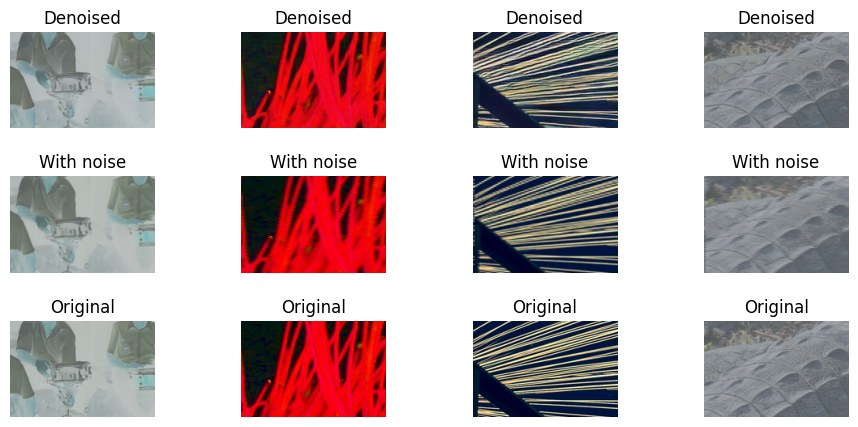

200/200 [==============================] - 96s 479ms/step - loss: 14208.0410 - lr_metric: 1.3348e-05 - mse: 170.7655 - accuracy: 0.8980 - val_loss: 15458.6816 - val_lr_metric: 1.3348e-05 - val_mse: 207.3410 - val_accuracy: 0.8846 - lr: 1.3348e-05
Epoch 87/120
200/200 [==============================] - ETA: 0s - loss: 15623.4102 - lr_metric: 1.3348e-05 - mse: 188.4816 - accuracy: 0.8962Saved denoised to Tensorboard
Saved with_noise to Tensorboard
Saved original to Tensorboard


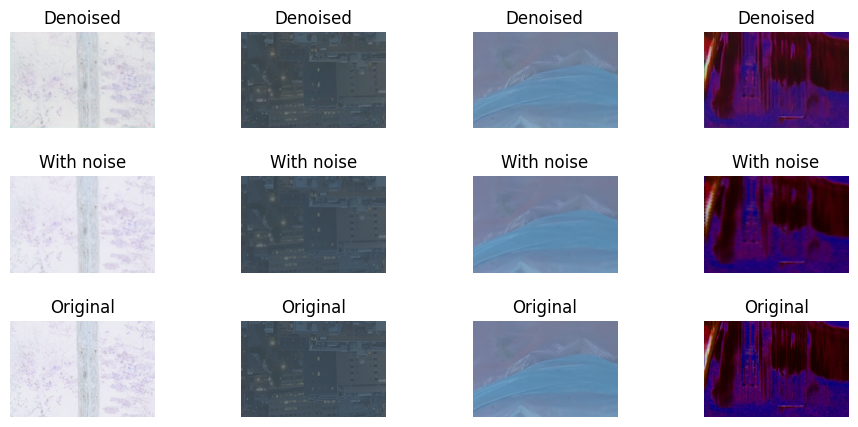

200/200 [==============================] - 99s 495ms/step - loss: 15623.4102 - lr_metric: 1.3348e-05 - mse: 188.4816 - accuracy: 0.8962 - val_loss: 17636.0195 - val_lr_metric: 1.3348e-05 - val_mse: 209.5977 - val_accuracy: 0.9075 - lr: 1.3348e-05
Epoch 88/120
200/200 [==============================] - ETA: 0s - loss: 13955.7627 - lr_metric: 1.3348e-05 - mse: 172.1397 - accuracy: 0.8945

KeyboardInterrupt: 

In [103]:
epochs = 120
lr = 1e-4
# lr = 1e-7
# model_name = "aenc/small_v7"
model_name = "aenc/small_v8"
output_shape = (120, 180)

def scheduler(epoch, lr):
    if epoch < 25:
        return 2e-05
    elif epoch < 50:
        return 1e-06
    else:
        return 1e-07
# .withLRRange([lr])\
# .withLRScheduler(tf.keras.callbacks.LearningRateScheduler(scheduler))\


train_config = TrainingConfig(dropout_rate=0.1,
                 ff_dropout_rate=0.2,
                 kernel_regularizer = tf.keras.regularizers.L2(1e-2),
                 learning_rate=[lr],
                optimizer="adam")

Trainer(model_name, output_shape)\
    .withVersion(1.2)\
    .withLRRange([lr])\
    .withTensorboard("prepa_autencoder_logs")\
    .withReduceLROnPlateau(
                monitor='val_loss',
                factor=0.75,
                patience=5,
                cooldown=1,
                min_lr=1e-7)\
    .withSaveModel("ae")\
    .withOptimizer(train_config.optimizer)\
    .onAfterTrain(save_layers(["decoder_small"], ['./weights/decoder_small']))\
    .train(
        build_ae_1(train_config, encoder_trainable=True),
        div2k_ds("train", output_shape).batch(4),
        div2k_ds("validation", output_shape).batch(2),
        epochs,
        lr,
        load_checkpoint=False,
        config=train_config)

In [ ]:
epochs = 100
lr = 1e-4
# lr = 1e-7
output_shape = (120, 176)

# def scheduler(epoch, lr):
#     if epoch < 25:
#         return 1e-07
#     else:
#         return 8e-07
# .withLRScheduler(tf.keras.callbacks.LearningRateScheduler(scheduler))\


train_config = TrainingConfig(dropout_rate=0.1,
                 ff_dropout_rate=0.1,
                 kernel_regularizer = tf.keras.regularizers.L2(1e-2),
                 learning_rate=[lr],
                optimizer="adam")

Trainer(model_name, output_shape)\
    .withVersion(1.2)\
    .withLRRange([lr])\
    .withTensorboard("prepa_autencoder_logs")\
    .withReduceLROnPlateau(
                monitor='val_loss',
                factor=0.7,
                patience=3,
                cooldown=1,
                min_lr=5e-7)\
    .withSaveModel("ae")\
    .onAfterTrain(save_weights(4, './weights/decoder_small'))\
    .train(
        build_ae_1(train_config, encoder_trainable=True),
        div2k_ds("train", output_shape).batch(4),
        div2k_ds("validation", output_shape).batch(2),
        epochs,
        lr,
        load_checkpoint=False,
        config=train_config)

In [ ]:
# model.save_weights('./weights/aenc_small')
# model.layers[4].save_weights('./weights/decoder_small')

In [ ]:
# sdecoder = smodel.layers[4]
# sdecoder.summary()

In [ ]:
# ds = div2k_ds("validation", (120,180)).batch(2)

# plt.imshow(tf.cast(smodel.predict(next(iter(ds))[0])[0], tf.uint8))

In [ ]:
# del smodel

In [ ]:
# lr = 1e-7
# train_config = TrainingConfig(dropout_rate=0.1,
#                  ff_dropout_rate=0.3,
#                  kernel_regularizer = tf.keras.regularizers.L2(1e-2),
#                  learning_rate=[lr],
#                 optimizer="adam")

# sdecoder = build_small_decoder(train_config)
# sdecoder.load_weights('./weights/decoder_small')

In [ ]:
#     base_model = tf.keras.models.load_model(weights_path)
# base_model = build_ae_1(train_config)
# base_model.load_weights('./weights/aenc_small')
    
def build_medium_decoder(config, input_shape=(120, 176, 24), output_shape=(240, 352)):
    assert len(output_shape) == 2

    inputs = keras.Input(shape=input_shape)
    
#     x = conv(512, 3, 1, name="conv1", use_bias=True, config=config)(inputs)
    x = tf.keras.layers.UpSampling2D(size=(2, 2), data_format=None, interpolation="nearest")(inputs)
    y = x
    x = Resblock(512, 3, name="resb1", config=config)(x)
#     x = layers.SpatialDropout2D(config.dropout_rate)(x)
    x = Resblock(256, 3, name="resb2", config=config)(x)

    x = Resblock(256, 3, name="resb3", config=config)(x)
    x = Resblock(128, 5, name="resb4", config=config)(x)
    x = Resblock(64, 3, name="resb5", config=config)(x)
    x = tf.concat([x,y], axis=-1)
    x = conv(64, 1, 1, name="mid_conv", use_bias=True, config=config)(x)
    
    x = tf.keras.layers.UpSampling2D(size=(2, 2), data_format=None, interpolation="nearest")(x)
    
    x = Resblock(64, 5, name="resb6", config=config)(x)
    x = Resblock(64, 3, name="resb7", config=config)(x)
   
#     y = resize_input(inputs, output_shape)
#     y = Resblock(64, 3, name="resb8", config=config)(y)
#     y = layers.SpatialDropout2D(config.ff_dropout_rate)(y)
    
#     x = tf.add(x, y)
#     x = layers.ReLU()(x)
#     x = Resblock(64, 5, name="resb9", config=config)(x)
    x = Resblock(32, 5, name="resb10", config=config)(x)
    x = Resblock(16, 3, name="resb11", config=config)(x)

    return tf.keras.Model(inputs, x, name="decoder_medium")

def build_ae_2(config, weights_path, small_trainable=False, output_shape=(240, 352)):
    h = 480
    w = 720
    
    
    encoder = VGG16(weights="imagenet", include_top=False, input_shape=(h, w, 3))
    for layer in encoder.layers:
        layer.trainable = False

    decoder_small = build_small_decoder(config)
    decoder_small.load_weights('./weights/decoder_small')
    for layer in decoder_small.layers:
        layer.trainable = small_trainable
    
    
    decoder_medium = build_medium_decoder(config, input_shape=(120, 176, 16), output_shape=output_shape)
    
    inputs = keras.Input(shape=(h, w, 3))
    norm = True
    
    x = tf.keras.applications.vgg16.preprocess_input(inputs)
    x_encoder = encoder(x)
    x = decoder_small([inputs, x_encoder])
#     x_encoder = conv(16, 3, 1, name="middle_conv", use_bias=True, config=config)(x_encoder)
#     x_encoder = resize_input(x_encoder, (120, 176))
    
# #     x_encoder = layers.Dense(120*176*16)(x_encoder)
# #     x_encoder = tf.reshape(x_encoder, (-1,120,176,8))
#     x = tf.concat([x, tf.cast(x_encoder, tf.float16)], axis=-1)
# #     x = tf.add(x, x_encoder)
#     x = layers.ReLU()(x)
    x = decoder_medium(x)
        
    x = conv(3, 3, 1, name="output_conv", activation="sigmoid", use_bias=True, config=config)(x)
    x = tf.keras.layers.Rescaling(255.)(x)
    
    model = tf.keras.Model(inputs, x, name="aenc_medium")
    print(model.summary())
    return model

# train_config = TrainingConfig(dropout_rate=0.1,
#                  ff_dropout_rate=0.3,
#                  kernel_regularizer = tf.keras.regularizers.L2(0.00001),
#                  learning_rate=[1e-4],
#                 optimizer="adam")
# build_ae_2(train_config, './weights/aenc_medium').summary()

#x = tf.image.resize(x, [360,540], preserve_aspect_ratio=False, antialias=False)


In [ ]:
epochs = 12
lr = 5e-5
# lr = 3e-5
model_name = "aenc/medium_v3"
# output_shape = (120, 180)
output_shape = (480, 704)
# output_shape = (240, 352)

# def scheduler(epoch, lr):
#     if epoch < 25:
#         return 1e-07
#     else:
#         return 8e-07
# .withLRScheduler(tf.keras.callbacks.LearningRateScheduler(scheduler))\

train_config = TrainingConfig(dropout_rate=0.1,
                 ff_dropout_rate=0.3,
                 kernel_regularizer = tf.keras.regularizers.L2(1e-2),
                 learning_rate=[lr],
                optimizer="adam")
Trainer(model_name, output_shape)\
    .withVersion(1.2)\
    .withLRRange([lr])\
    .withTensorboard("prepa_autencoder_logs")\
    .withSaveModel("ae2")\
    .withReduceLROnPlateau(
                monitor='val_loss',
                factor=0.7,
                patience=2,
                cooldown=1,
                min_lr=5e-7)\
    .onAfterTrain(save_weights(12, './weights/decoder_medium'))\
    .train(
        build_ae_2(train_config, './weights/aenc_medium'),
        div2k_ds("train", output_shape).batch(3),
        div2k_ds("validation", output_shape).batch(2),
        epochs,
        lr,
        load_checkpoint=False,
        config=train_config)


In [ ]:
epochs = 20
lr = 1e-6
model_name = "aenc/medium_v3_tune"
# output_shape = (120, 180)
output_shape = (480, 704)
# output_shape = (240, 352)

def scheduler(epoch, lr):
    if epoch < 25:
        return 3e-6
    else:
        return 5e-7


train_config = TrainingConfig(dropout_rate=0.1,
                 ff_dropout_rate=0.3,
                 kernel_regularizer = tf.keras.regularizers.L2(1e-2),
                 learning_rate=[lr],
                optimizer="adam")
Trainer(model_name, output_shape)\
    .withVersion(1.2)\
    .withLRRange([lr])\
    .withTensorboard("prepa_autencoder_logs")\
    .withSaveModel("ae2")\
    .withLRScheduler(tf.keras.callbacks.LearningRateScheduler(scheduler))\
    .onAfterTrain(save_multiple_weights([(4, './weights/decoder_small'), (5, './weights/decoder_medium')]))\
    .train(
        build_ae_2(train_config, './weights/aenc_medium', small_trainable=True),
        div2k_ds("train", output_shape).batch(3),
        div2k_ds("validation", output_shape).batch(2),
        epochs,
        lr,
        load_checkpoint=True,
        config=train_config)


In [ ]:
# model.save_weights('./weights/aenc_medium')
# model.layers[12].save_weights('./weights/decoder_medium')

In [ ]:
# model.layers[12].name

In [ ]:
720/2,1080/2

In [ ]:
#     base_model = tf.keras.models.load_model(weights_path)
# base_model = build_ae_1(train_config)
# base_model.load_weights('./weights/aenc_small')
    
def build_large_decoder(config, input_shape=(120, 176, 24), output_shape=(720, 1080)):
    assert len(output_shape) == 2

    inputs = keras.Input(shape=input_shape)
    
    x = resize_input(x, (360, 540))
    x = Resblock(512, 3, name="resb1", config=config)(inputs)
    x = Resblock(256, 3, name="resb2", config=config)(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2), data_format=None, interpolation="nearest")(x)
    
    x = Resblock(256, 3, name="resb3", config=config)(x)
    x = Resblock(128, 5, name="resb4", config=config)(x)
    x = Resblock(64, 3, name="resb5", config=config)(x)
    x = Resblock(16, 3, name="resb11", config=config)(x)

    return tf.keras.Model(inputs, x, name="decoder_large")

def build_ae_3(config, weights_path, small_trainable=False, medium_trainable=False, output_shape=(720,1080)):
    h = 480
    w = 720
    
    
    encoder = VGG16(weights="imagenet", include_top=False, input_shape=(h, w, 3))
    for layer in encoder.layers:
        layer.trainable = False

    decoder_small = build_small_decoder(config)
    decoder_small.load_weights('./weights/decoder_small')
    for layer in decoder_small.layers:
        layer.trainable = small_trainable
    
    
    decoder_medium = build_medium_decoder(config, input_shape=(120, 176, 32), output_shape=(480, 704))
    decoder_medium.load_weights('./weights/decoder_medium')
    for layer in decoder_medium.layers:
        layer.trainable = medium_trainable
        
    large_decoder = build_large_decoder(config, input_shape=(480, 704, 32), output_shape=(720,1080))
    print(large_decoder.summary())
    
    inputs = keras.Input(shape=(h, w, 3))
    norm = True
    
    x = tf.keras.applications.vgg16.preprocess_input(inputs)
    x_encoder = encoder(x)
    x = decoder_small([inputs, x_encoder])
    x_encoder = conv(16, 3, 1, name="middle_conv", use_bias=True, config=config)(x_encoder)
    x_encoder = resize_input(x_encoder, (120, 176))
    
#     x_encoder = layers.Dense(120*176*16)(x_encoder)
#     x_encoder = tf.reshape(x_encoder, (-1,120,176,8))
    x = tf.concat([x, tf.cast(x_encoder, tf.float16)], axis=-1)
#     x = tf.add(x, x_encoder)
    x = layers.ReLU()(x)
    x = decoder_medium(x)
    
    x_encoder = resize_input(x_encoder, (480, 704))
    x = tf.concat([x, tf.cast(x_encoder, tf.float16)], axis=-1)
    x = layers.ReLU()(x)
    x = large_decoder(x)
    
    
    x = conv(3, 3, 1, name="output_conv", activation="sigmoid", use_bias=True, config=config)(x)
    x = tf.keras.layers.Rescaling(255.)(x)
    
    model = tf.keras.Model(inputs, x, name="aenc_large")
    print(model.summary())
    return model


#x = tf.image.resize(x, [360,540], preserve_aspect_ratio=False, antialias=False)


In [ ]:
epochs = 2
lr = 5e-5
# lr = 3e-5
model_name = "aenc/large_v3"
# output_shape = (120, 180)
output_shape = (720, 1080)
# output_shape = (240, 352)

# def scheduler(epoch, lr):
#     if epoch < 25:
#         return 1e-07
#     else:
#         return 8e-07
# .withLRScheduler(tf.keras.callbacks.LearningRateScheduler(scheduler))\

train_config = TrainingConfig(dropout_rate=0.1,
                 ff_dropout_rate=0.3,
                 kernel_regularizer = tf.keras.regularizers.L2(1e-2),
                 learning_rate=[lr],
                optimizer="adam")
weights_path, ghistory, model = Trainer(model_name, output_shape)\
    .withVersion(1.2)\
    .withLRRange([lr])\
    .withTensorboard("prepa_autencoder_logs")\
    .withSaveModel("ae2")\
    .withReduceLROnPlateau(
                monitor='val_loss',
                factor=0.7,
                patience=2,
                cooldown=1,
                min_lr=5e-7)\
    .train(
        build_ae_3(train_config, './weights/aenc_large'),
        div2k_ds("train", output_shape).batch(3),
        div2k_ds("validation", output_shape).batch(2),
        epochs,
        lr,
        load_checkpoint=False,
        config=train_config)


In [ ]:
def restore_grad_acc_model(model_name, model_fn):
    model = model_fn()
    model.load_weights(f'./saved_models/{model_name}')
    return model

def restore_from_checkpoint(name):
    autoencoder = build_autoencoder_large_v3(train_config)
    checkpoint_dir = f'./prepa_{name}_ckpt'
    checkpoint = tf.train.Checkpoint(model=autoencoder)
    ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

    if ckpt_manager.latest_checkpoint:
#             checkpoint.restore(ckpt_manager.latest_checkpoint)
            checkpoint.restore(ckpt_manager.latest_checkpoint).expect_partial()
    else:
        print("No checkpoints found or loaded")
    return autoencoder

def test_prepa(autoencoder): 
    
    
    prepa = [(str(p),'png') for p in pathlib.Path("./prepa").glob('*.png')]

    def gen_img(img_path, img_type):
        raw_png = tf.io.read_file(str(img_path), name=img_path)
        return tf.image.decode_png(raw_png, channels=3, name=img_path)

    def gen_prepa():
        for img_path, img_type in prepa:
            yield gen_img(img_path, img_type)

    it = iter(gen_prepa())    
    for i in range(10):


        img = next(it)
        plt.figure()
        plt.imshow(img)
        plt.figure()
        y_pred = autoencoder.predict(tf.expand_dims(img, axis=0), verbose=0)
        y_pred = tf.cast(y_pred, tf.uint8)
        plt.imshow(y_pred[0])


    # tf.math.reduce_mean(
    #     y_pred, axis=[1,2], keepdims=False, name=None
    # )

    # y = tf.reshape(y_pred, (1,-1,3))
    # y = layers.AveragePooling1D(2)(tf.cast(y, tf.float32))
    # y = layers.AveragePooling1D(2)(tf.cast(y, tf.float32))
    # y = layers.AveragePooling1D(2)(tf.cast(y, tf.float32))
    # # y = tf.image.resize(y, (720, 1080))
    # y
test_prepa(model)
# test_prepa(restore_from_checkpoint("aenc/t02_071"))


In [ ]:
# m = restore_grad_acc_model("denoise_and_scale_100e_large_v3_0002", build_autoencoder_large_v3)

In [ ]:
model.summary()

In [ ]:
model.save('./saved_models/denoise_autoencoder_v1')